In [35]:
# Set the process name to be human readable in htop
import setproctitle
setproctitle.setproctitle("Prep_Figure_1")

import requests
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np
import helper as my

import glob
import os
import sys

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Fetch ACE2 Pop Vars

In [2]:
import requests
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np

# Borrowed From https://gist.github.com/ressy/6fd7f6ee6401ac8e703dc2709399869e
# See also Docs at (https://gnomad.broadinstitute.org/api)
def fetch_gnomAD(jsondata, url="https://gnomad.broadinstitute.org/api"):
    # The server gives a generic error message if the content type isn't
    # explicitly set
    headers = {"Content-Type": "application/json"}
    response = requests.post(url, json=jsondata, headers=headers)
    json = response.json()
    if "errors" in json:
        raise Exception(str(json["errors"]))
    return json
# FUNCTION END

# Borrowed From https://gist.github.com/ressy/6fd7f6ee6401ac8e703dc2709399869e
# See also Docs at (https://gnomad.broadinstitute.org/api)
def queryGnomadByGene(gene_name, dataset="gnomad_r2_1", fields=["gene_id", "gene_symbol", "chrom", "pos", "ref", "alt", "consequence", "rsid", "variantId", "hgvsp"]):
    # Note that this is GraphQL, not JSON.
    fmt_graphql = """
    {
        gene(gene_name: "%s") {
          variants(dataset: %s) {
          %s
        }
      }
    }
    """
    # This part will be JSON encoded, but with the GraphQL part left as a
    # glob of text.
    req_variantlist = {
        "query": fmt_graphql % (gene_name, dataset, "\n".join(fields)),
        "variables": {}
        }
    response = fetch_gnomAD(req_variantlist)
    return pd.DataFrame(response["data"]["gene"]["variants"])[fields]
# FUNCTION END
pop_vars = queryGnomadByGene("ACE2")

In [4]:
pop_vars["chrom"] = pop_vars["chrom"].map(lambda x: int(x) if not x == "X" else x)
pop_vars = pop_vars.drop_duplicates().sort_values(["chrom", "pos"])

In [29]:
pop_vars = pop_vars[pop_vars["consequence"] == "missense_variant"]

In [5]:
out = open("VEP_Input.txt", "w+")
out.write("\n".join(pop_vars[["chrom", "pos", "ref", "alt"]].apply(lambda x: "{0} {1} . {2} {3}".format(*x), axis=1)))
out.close()

In [30]:
# Read in VEP Mapped Variants
vep_mapped = pd.read_csv("VEP_Output.txt", sep="\t")
vep_mapped = vep_mapped[vep_mapped["Consequence"] == "missense_variant"]

In [31]:
# Join on Key
vep_mapped["Key"] = vep_mapped[["Location", "Allele"]].apply(lambda x: x[0].split("-")[0] + x[1], axis=1)
pop_vars["Key"] = pop_vars[["chrom", "pos", "alt"]].apply(lambda x: str(x[0]) + ":" + str(x[1]) + x[2], axis=1)

# Make sure the same variants are included in both
s1 = set(pop_vars["Key"])
s2 = set(vep_mapped["Key"])
print s1 == s2

# Merge
merged = pop_vars.join(vep_mapped.set_index("Key"), how="outer", on="Key")

False


[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [46]:
# Get expected UniProt from original input / compare against VEP Mapping
gene2uniprot = {"ACE2":"Q9BYF1"}
merged["Expected_UniProt"] = merged["gene_symbol"].map(lambda x: gene2uniprot[x])

# Drop any cases with wrong UniProt mapping (there are only 2 here so its not a big deal)
merged = merged[merged["SWISSPROT"] == merged["Expected_UniProt"]]#.drop_duplicates("Key") # We don't drop duplicates yet because there are some with multiple Protein PositionsU

In [47]:
# Select / Rename Columns
merged["AA_Ref"] = merged["Amino_acids"].map(lambda x: x.split("/")[0])
merged["AA_Alt"] = merged["Amino_acids"].map(lambda x: x.split("/")[1])
merged["SIFT_Category"] = merged["SIFT"].map(lambda x: x.split("(")[0] if not x == "-" else np.nan)
merged["SIFT_Score"] = merged["SIFT"].map(lambda x: float(x.split("(")[1].strip(")")) if not x == "-" else np.nan)
merged["PolyPhen_Category"] = merged["PolyPhen"].map(lambda x: x.split("(")[0] if not x == "-" else np.nan)
merged["PolyPhen_Score"] = merged["PolyPhen"].map(lambda x: float(x.split("(")[1].strip(")")) if not x == "-" else np.nan)
merged = merged[["gene_symbol", "gene_id", "SWISSPROT", "chrom", "pos", "ref", "alt", "consequence", "rsid", "IMPACT", "Protein_position", "AA_Ref", "AA_Alt", "SIFT_Category", "SIFT_Score", "PolyPhen_Category", "PolyPhen_Score", "gnomAD_AF", "CLIN_SIG", "SOMATIC", "PHENO"]]

In [48]:
merged.columns = ["Gene_Symbol", "Gene_ID", "UniProt", "Chrom", "Pos", "Ref", "Alt", "Consequence", "rsID", "Imact", "AA_Pos", "AA_Ref", "AA_Alt", "SIFT_Category", "SIFT_Score", "PolyPhen_Category", "PolyPhen_Score", "gnomAD_AF", "Clinical_Significance", "Somatic", "Pheno"]

In [67]:
# Make sure all mapped uniprot positions references match
#uni2seq = {"Q9BYF1":my.get_Fasta("Q9BYF1")}
merged["Accurate_Pos"] = merged[["UniProt", "AA_Pos", "AA_Ref"]].apply(lambda x: uni2seq[x[0]][int(x[1]) - 1] == x[2] if int(x[1]) <= len(uni2seq[x[0]]) else False, axis=1)

tmp = merged.sort_values(["Chrom", "Pos", "Accurate_Pos"], ascending=[True, True, False]).drop_duplicates(["Chrom", "Pos", "Ref", "Alt"])

In [68]:
tmp["Accurate_Pos"].mean()

1.0

In [69]:
len(tmp)

239

In [70]:
len(pop_vars)

252

In [71]:
tmp = tmp[tmp["Accurate_Pos"]]
tmp = tmp.drop("Accurate_Pos", axis=1)

In [73]:
tmp.to_csv("ACE2_Pop_Vars.txt", sep="\t", index=None)

# Run Pop Var ddG Calculations

In [522]:
pop_vars = pd.read_csv("ACE2_Pop_Vars.txt", sep="\t")

In [523]:
import subprocess as sp
out = sp.check_output("irescalc.py -c1 A -c2 B COVIDSPIKEACE2.pdb", shell=True)

In [524]:
iresA, iresB = out.strip().split("\n")
iresA = [int(x) for x in iresA.split(",")]
iresB = [int(x) for x in iresB.split(",")]

In [525]:
out = sp.check_output("irescalc.py -c1 A -c2 B SARSSPIKEACE2.pdb", shell=True)

In [526]:
iresC, iresD = out.strip().split("\n")
iresC = [int(x) for x in iresC.split(",")]
iresD = [int(x) for x in iresD.split(",")]

In [118]:
for pos, ref, alt in tqdm_notebook(pop_vars[pop_vars["AA_Pos"].map(lambda x: x in iresB)][["AA_Pos", "AA_Ref", "AA_Alt"]].values):
    p = sp.Popen("python Mutant_ddG_Calc.py COVIDSPIKE ACE2_{0}{1}{2} COVIDSPIKEACE2.pdb 1 {1}_{2} 10 8".format(ref, pos, alt), shell=True)

In [ ]:
# Spike Mut Enrichment

In [527]:
seq1 = pd.read_csv("../Data/Proteins.txt", sep="\t")
seq1 = seq1[seq1["ID"] == "COVID19Spike"]["Sequence"].values[0]
spike_ires_mask = np.zeros(len(seq1))
spike_ires_mask[[x - 1 for x in iresA]] = 1

tmp = pd.read_csv("../Data/Viral_Muts.txt", sep="\t")
mut_pos = tmp[(tmp["COVID_ID"].map(lambda x: "SPIKE" in x.upper()))]["COVID_Pos"].values
spike_mut_mask = np.zeros(len(seq1))
spike_mut_mask[mut_pos-1] = 1

pdb_df = my.pdb2df("COVIDSPIKEACE2.pdb")
spike_coverage_mask = np.zeros(len(seq1))
spike_coverage_mask[pdb_df[pdb_df["Chain"] == "A"]["Residue ID"].unique() - 1] = 1

In [539]:
OR, up, low, p = my.odds_ratio(spike_ires_mask, spike_mut_mask, verbose=True, error="SE")
OR, up, low = np.log2([OR, up, low])
print OR, up, low, p

              Case  Non-Case
Exposed       15.0       8.0
Non-Exposed  283.0     967.0
2.67960443225 3.31869449908 2.04051436542 2.75479878271e-05


In [532]:
scipy.stats.norm.ppf(1-0.025)

1.959963984540054

In [533]:
np.log2(0.5762)

-0.79535843438957887

In [545]:
OR, up, low, p = my.odds_ratio(spike_ires_mask[spike_coverage_mask == 1], spike_mut_mask[spike_coverage_mask == 1], verbose=True, error="SE", two_sided=False)
OR, up, low = np.log2([OR, up, low])
print OR, up, low, p

             Case  Non-Case
Exposed      15.0       8.0
Non-Exposed  36.0     136.0
2.82442843542 3.5114866887 2.13737018213 1.97059115767e-05


In [2]:
import numpy as np
import helper as my

In [535]:
my = reload(my)

In [538]:
a = 15
b = 8
c = 36
d = 136
exposure_mask = np.zeros(sum([a, b, c, d]))
case_mask = np.zeros(sum([a, b, c, d]))
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, error="SE")

             Case  Non-Case
Exposed      15.0       8.0
Non-Exposed  36.0     136.0


(2.8244284354165456,
 3.5114866886997298,
 2.1373701821333619,
 3.941182315347902e-05)

In [481]:
# ACE2 Pop-var Enrichment

In [541]:
seq2 = my.get_Fasta("Q9BYF1")
ace2_ires_mask = np.zeros(len(seq2))
ace2_ires_mask[[x - 1 for x in iresB]] = 1


mut_pos = pop_vars["AA_Pos"].unique()
ace2_mut_mask = np.zeros(len(seq2))
ace2_mut_mask[mut_pos-1] = 1

pdb_df = my.pdb2df("COVIDSPIKEACE2.pdb")
ace2_coverage_mask = np.zeros(len(seq2))
ace2_coverage_mask[pdb_df[pdb_df["Chain"] == "B"]["Residue ID"].unique() - 1] = 1

In [542]:
OR, up, low, p = my.odds_ratio(ace2_ires_mask, ace2_mut_mask, verbose=True, error="SE")
OR, up, low = np.log2([OR, up, low])
print OR, up, low, p

              Case  Non-Case
Exposed        6.0      14.0
Non-Exposed  205.0     580.0
0.278036569173 0.991693090004 -0.435619951658 0.696836509146


In [544]:
OR, up, low, p = my.odds_ratio(ace2_ires_mask[ace2_coverage_mask == 1], ace2_mut_mask[ace2_coverage_mask == 1], verbose=True, error="SE", two_sided=False)
OR, up, low = np.log2([OR, up, low])
print OR, up, low, p

              Case  Non-Case
Exposed        6.0      14.0
Non-Exposed  143.0     433.0
0.375959456612 1.09354285086 -0.341623937639 0.300165557981


In [492]:
pop_vars[pop_vars["AA_Pos"].map(lambda x: x in iresB)][["AA_Ref", "AA_Pos", "AA_Alt", "gnomAD_AF"]].sort_values("AA_Pos")

,AA_Ref,AA_Pos,AA_Alt,gnomAD_AF
234,S,19,P,0.0002518
228,T,27,A,1.091e-05
227,E,35,K,1.636e-05
226,E,37,K,3.273e-05
212,M,82,I,1.094e-05
151,G,326,E,5.517e-06


In [496]:
vmax = 4
cmapddG = lambda x: matplotlib.cm.seismic(float((x + vmax)) / (vmax*2.0)) if abs(x != vmax) else matplotlib.cm.seismic([0.0, 1.0][x > 0])
print matplotlib.colors.rgb2hex(cmapddG(0.88)[:3])
print matplotlib.colors.rgb2hex(cmapddG(0.13)[:3])
print matplotlib.colors.rgb2hex(cmapddG(-0.85)[:3])
print matplotlib.colors.rgb2hex(cmapddG(1.5)[:3])
print matplotlib.colors.rgb2hex(cmapddG(2.95)[:3])
print matplotlib.colors.rgb2hex(cmapddG(5.74)[:3])
print matplotlib.colors.rgb2hex(cmapddG(-5.74)[:3])

#ff8d8d
#ffeded
#9191ff
#ff3d3d
#c20000
#800000
#00004c


# Parse and Generate PyMol Session

In [224]:
from collections import defaultdict

In [346]:
def fetch_scores_from_pdb(pdb, pdb_df=None, relabel=True):
    if(relabel and (pdb_df is None)):
        pdb_df = my.pdb2df(pdb)
    
    lines = my.easyReadLines(pdb)
    keep = []
    flag = True
    for l in lines:
        if(flag and not "#BEGIN" in l):
            continue
        else:
            flag = False
            keep.append(l)
    scores1 = pd.DataFrame([x.split() for x in keep[3:-2]], columns=keep[1].split())
    
    if(relabel):
        scores1["Chain"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Chain"].to_list()
        scores1["Res"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue Name"].to_list()
        scores1["Resi"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue ID"].to_list()
        
        scores1 = scores1[["Chain", "Res", "Resi"] + list(scores1)[1:-3]]
    
    return scores1
# FUNCTION END

def calc_ddG_per_residue(base, pdb_df=None):
    wt_comp = sorted(glob.glob("{0}_*WT_Complex.pdb".format(base)))
    mut_comp = sorted(glob.glob("{0}_*Mut_Complex.pdb".format(base)))
    wt_sep = sorted(glob.glob("{0}_*WT_Separate.pdb".format(base)))
    mut_sep = sorted(glob.glob("{0}_*Mut_Separate.pdb".format(base)))
    
    pdb_df = my.pdb2df(wt_comp[0])
    
    trials = []
    for wt_c, wt_sep, mut_c, mut_sep in zip(wt_comp, wt_sep, mut_comp, mut_sep):
        a = fetch_scores_from_pdb(wt_c, relabel=False)
        b = fetch_scores_from_pdb(wt_sep, relabel=False)
        
        c = fetch_scores_from_pdb(mut_c, relabel=False)
        d = fetch_scores_from_pdb(mut_sep, relabel=False)
        
        ddg = (c[list(c)[1:]].astype(float) - d[list(d)[1:]].astype(float)) - (a[list(a)[1:]].astype(float) - b[list(b)[1:]].astype(float))
        
        trials.append(ddg)
    ddg = sum(trials) / float(len(trials))
    
    ddg["Chain"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Chain"].to_list()
    ddg["Res"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue Name"].to_list()
    ddg["Resi"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue ID"].to_list()
    
    ddg = ddg[["Chain", "Res", "Resi"] + list(ddg)[:-3]]
    
    return ddg
# FUNCTION END

In [ ]:
#    wt_pdb = "Pop_Vars/Structures/COVIDSPIKE_{0}_1_SARS_Muts_1WT_Complex.pdb".format(mut)
#    lines = my.easyReadLines(wt_pdb)
#    keep = []
#    flag = True
#    for l in lines:
#        if(flag and not "#BEGIN" in l):
#            continue
#        else:
#            flag = False
#            keep.append(l)
#    scores1 = pd.DataFrame([x.split() for x in keep[3:-2]], columns=keep[1].split())
#    scores1["Chain"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Chain"].to_list()
#    scores1["Res"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue Name"].to_list()
#    scores1["Resi"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue ID"].to_list()
#    
#    scores1 = scores1[["Chain", "Res", "Resi"] + list(scores1)[1:-3]]
#    
#    
#    mut_pdb = "Pop_Vars/Structures/COVIDSPIKE_{0}_1_SARS_Muts_1Mut_Complex.pdb".format(mut)
#    lines = my.easyReadLines(mut_pdb)
#    keep = []
#    flag = True
#    for l in lines:
#        if(flag and not "#BEGIN" in l):
#            continue
#        else:
#            flag = False
#            keep.append(l)
#    scores2 = pd.DataFrame([x.split() for x in keep[3:-2]], columns=keep[1].split())
#    scores2["Chain"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Chain"].to_list()
#    scores2["Res"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue Name"].to_list()
#    scores2["Resi"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue ID"].to_list()
#    
#    scores2 = scores2[["Chain", "Res", "Resi"] + list(scores2)[1:-3]]
#    
#    merged = scores1.join(scores2.set_index(["Chain", "Res", "Resi"]), on=["Chain", "Res", "Resi"], lsuffix="_WT", rsuffix="_Mut")
#    
#    merged["ddG_Resi"] = merged["total_Mut"].astype(float) - merged["total_WT"].astype(float)

In [379]:
pdb_df = my.pdb2df("COVIDSPIKEACE2.pdb")
outs = glob.glob("Pop_Vars/Summaries/*")
mut2data = defaultdict(dict)
for f in outs:
    tmp = pd.read_csv(f, sep="\t")
    mut = tmp["P2"].values[0]
    ddG = tmp["ddG"].mean()
    std = tmp["ddG"].std()
    print mut, ddG, std
    
    wt_pdb = "Pop_Vars/Structures/COVIDSPIKE_{0}_1_SARS_Muts_1WT_Complex.pdb".format(mut)
    mut_pdb = "Pop_Vars/Structures/COVIDSPIKE_{0}_1_SARS_Muts_1Mut_Complex.pdb".format(mut)
    resi_ddG = calc_ddG_per_residue("Pop_Vars/Structures/COVIDSPIKE_{0}_1_SARS_Muts".format(mut))
    
    mut2data[mut] = {"ddG":ddG, "std":std, "resi_ddG":resi_ddG, "mut_pdb":mut_pdb, "wt_pdb":wt_pdb}

ACE2_M82I 2.94740352852 0.0
ACE2_S19P 0.888439336491 0.0706365399432
ACE2_G326E 5.74394875325 0.0
ACE2_E35K -0.848625092391 0.55879471787
ACE2_T27A 0.133794748405 0.0222085617201
ACE2_E37K 1.4956105952 0.0236769476454


In [395]:
k = mut2data.keys()[5]
print k
tmp = mut2data[k]["resi_ddG"]
tmp[tmp["total"].abs() > 0.01]

ACE2_G326E


,Chain,Res,Resi,fa_atr,fa_rep,fa_sol,hbond_bb_sc,hbond_sc,total
0,NA,NA,NA,-4.31000,0.21600,10.30000,-0.31250,-0.14810,5.74400
23,B,TYR,41,-0.35715,0.03726,0.80599,0.00000,0.00000,0.48609
307,B,GLN,325,-0.02425,0.00000,-0.01823,0.00000,0.00000,-0.04248
308,B,GLY,326,-0.71675,0.02021,2.25034,0.00000,0.00000,1.55380
309,B,PHE,327,0.00173,0.00000,-0.01383,0.00000,0.00000,-0.01210
311,B,GLU,329,0.03452,-0.00004,-0.07268,0.00000,0.00000,-0.03820
312,B,ASN,330,0.03068,0.03239,0.00689,0.00000,0.00000,0.06995
333,B,LEU,351,-0.03185,0.01838,0.14847,0.00000,0.00000,0.13500
334,B,GLY,352,-0.00362,0.00224,0.02998,0.00000,0.00000,0.02859
335,B,LYS,353,-0.60205,0.00696,1.17725,0.00000,0.00000,0.58216


In [384]:
mut2()[2]

'ACE2_E37K'

In [358]:
import __main__
__main__.pymol_argv = ['pymol','-cqk'] # Pymol: quiet and no GUI

import pymol
pymol.finish_launching()
from pymol import cmd as pymolCmd

In [359]:
import time

In [404]:
def polarpairs(sel1, sel2, cutoff=4.0, angle=63.0, name='', state=1, quiet=1):
    '''
ARGUMENTS

    sel1, sel2 = string: atom selections

    cutoff = float: distance cutoff

    angle = float: h-bond angle cutoff in degrees. If angle="default", take
    "h_bond_max_angle" setting. If angle=0, do not detect h-bonding.

    name = string: If given, also create a distance object for visual representation

SEE ALSO

    pymolCmd.find_pairs, pymolCmd.distance
    '''
    cutoff = float(cutoff)
    quiet = int(quiet)
    state = int(state)
    if angle == 'default':
        angle = pymolCmd.get('h_bond_max_angle', pymolCmd.get_object_list(sel1)[0])
    angle = float(angle)
    mode = 1 if angle > 0 else 0
    x = pymolCmd.find_pairs('(%s) and donors' % sel1, '(%s) and acceptors' % sel2,
            state, state,
            cutoff=cutoff, mode=mode, angle=angle) + \
        pymolCmd.find_pairs('(%s) and acceptors' % sel1, '(%s) and donors' % sel2,
            state, state,
            cutoff=cutoff, mode=mode, angle=angle)
    x = sorted(set(x))
    if not quiet:
        print('Settings: cutoff=%.1fangstrom angle=%.1fdegree' % (cutoff, angle))
        print('Found %d polar contacts' % (len(x)))
    if len(name) > 0:
        for p in x:
            pymolCmd.distance(name, '(%s`%s)' % p[0], '(%s`%s)' % p[1])
    return x
# FUNCTION END

pymolCmd.extend('polarpairs', polarpairs)

<function __main__.polarpairs>

In [426]:
pymolCmd.reinitialize()
count = 0

# Load COVID / SARS Interactions
name1A = "COVID_Spike"
name1B = "COVID_ACE2"
name2A = "SARS_Spike"
name2B = "SARS_ACE2"
pymolCmd.load("COVIDSPIKEACE2.pdb", name1A)
pymolCmd.extract(name1B, name1A + " and chain B")
pymolCmd.load("SARSSPIKEACE2.pdb", name2A)
pymolCmd.align(name2A, name1B)
pymolCmd.extract(name2B, name2A + " and chain B")

# Initial Display Settings
pymolCmd.show("cartoon", "all")
pymolCmd.hide("lines", "all")

cmapA = matplotlib.cm.Blues
cmapB = matplotlib.cm.Greens
covid_spike_ires = "chain A and (resi {0})".format(" or resi ".join([str(x) for x in iresA]))
covid_ace2_ires = "chain B and (resi {0})".format(" or resi ".join([str(x) for x in iresB]))
pymolCmd.select("COVID_Spike_Ires", covid_spike_ires)
pymolCmd.select("COVID_Ace2_Ires", covid_ace2_ires)
sars_spike_ires = "chain A and (resi {0})".format(" or resi ".join([str(x) for x in iresC]))
sars_ace2_ires = "chain B and (resi {0})".format(" or resi ".join([str(x) for x in iresD]))
pymolCmd.select("SARS_Spike_Ires", sars_spike_ires)
pymolCmd.select("SARS_Ace2_Ires", sars_ace2_ires)
pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.24)[:3]).replace("#", "0x"), "chain A")
pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.24)[:3]).replace("#", "0x"), "chain B")
pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.48)[:3]).replace("#", "0x"), "COVID_Spike_Ires and COVID_Spike")
pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.48)[:3]).replace("#", "0x"), "COVID_Ace2_Ires and COVID_ACE2")
pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.48)[:3]).replace("#", "0x"), "SARS_Spike_Ires and SARS_Spike")
pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.48)[:3]).replace("#", "0x"), "SARS_Ace2_Ires and SARS_ACE2")

# Display lines for Ires
pymolCmd.show("lines", "(COVID_Spike_Ires and COVID_Spike) or (COVID_Ace2_Ires and COVID_ACE2) or (SARS_Spike_Ires and SARS_Spike) or (SARS_Ace2_Ires and SARS_ACE2)")

# Load up Mutations
tmp = pd.read_csv("../Data/Viral_Muts.txt", sep="\t")
covid_pos = tmp[(tmp["COVID_ID"].map(lambda x: "SPIKE" in x.upper()))&(tmp["COVID_Pos"].map(lambda x: x in iresA))]["COVID_Pos"].values
sars_pos = tmp[(tmp["COVID_ID"].map(lambda x: "SPIKE" in x.upper()))&(tmp["COVID_Pos"].map(lambda x: x in iresA))]["SARS_Pos"].values

# Color Mutations
for p in covid_pos:
    pymolCmd.color("firebrick", "COVID_Spike and resi {0} and (not backbone)".format(p))
    pymolCmd.show("sticks", "COVID_Spike and resi {0} and (name CA or not backbone)".format(p))
pairs1 = polarpairs("COVID_Spike and (resi {0})".format(" or resi ".join([str(x) for x in covid_pos])), "COVID_ACE2", name="COVID_Polar_Pairs")
pymolCmd.copy_to("COVID_Spike_Muts", "COVID_Spike and name CA and (resi {0})".format(" or resi ".join([str(x) for x in covid_pos])))
pymolCmd.hide("everything", "COVID_Spike_Muts")
pymolCmd.show("spheres", "COVID_Spike_Muts")
pymolCmd.color("firebrick", "COVID_Spike_Muts")

for p in sars_pos:
    pymolCmd.color("firebrick", "SARS_Spike and resi {0} and (not backbone)".format(p))
    pymolCmd.show("sticks", "SARS_Spike and resi {0} and (name CA or not backbone)".format(p))
pairs2 = polarpairs("SARS_Spike and (resi {0})".format(" or resi ".join([str(x) for x in sars_pos])), "SARS_ACE2", name="SARS_Polar_Pairs")
if(len(pairs1)):
    pymolCmd.hide("labels", "COVID_Polar_Pairs")
if(len(pairs2)):
    pymolCmd.hide("labels", "SARS_Polar_Pairs")

# Color by element
pymolCmd.color("atomic", "not element C")

# Hide Hydrogens
pymolCmd.hide("everything", "element h".format(all_sele))

# Create super surface
pymolCmd.copy_to("COVID_Spike_Surface", "COVID_Spike")
pymolCmd.copy_to("COVID_ACE2_Surface", "COVID_ACE2")
pymolCmd.copy_to("SARS_Spike_Surface", "SARS_Spike")
pymolCmd.copy_to("SARS_ACE2_Surface", "SARS_ACE2")
pymolCmd.hide("everything", "COVID_Spike_Surface or SARS_Spike_Surface or COVID_ACE2_Surface or SARS_ACE2_Surface")
pymolCmd.show("surface", "COVID_Spike_Surface or SARS_Spike_Surface or COVID_ACE2_Surface or SARS_ACE2_Surface")
pymolCmd.set("transparency", 0.6)
pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.24)[:3]).replace("#", "0x"), "COVID_Spike_Surface or SARS_Spike_Surface")
pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.24)[:3]).replace("#", "0x"), "COVID_ACE2_Surface or SARS_ACE2_Surface")
pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.48)[:3]).replace("#", "0x"), "({0} and COVID_Spike_Surface) or ({1} and SARS_Spike_Surface)".format(covid_spike_ires, sars_spike_ires))
pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.48)[:3]).replace("#", "0x"), "({0} and COVID_ACE2_Surface) or ({1} and SARS_ACE2_Surface)".format(covid_ace2_ires, sars_ace2_ires))

count = 1
pymolCmd.select("-"*count, "chain Z")
count += 1

for mut in tqdm_notebook(mut2data):
    ddG, std, merged, mut_pdb, wt_pdb = mut2data[mut]["ddG"],  mut2data[mut]["std"],  mut2data[mut]["resi_ddG"],  mut2data[mut]["mut_pdb"],  mut2data[mut]["wt_pdb"]
    
    # Load Structures / Split by Chain
    name1A = mut + "_WTA"
    name1B = mut + "_WTB"
    name2A = mut + "_MutA"
    name2B = mut + "_MutB"
    pymolCmd.load(mut_pdb, name2A)
    pymolCmd.extract(name2B, name2A + " and chain B")
    pymolCmd.load(wt_pdb, name1A)
    pymolCmd.extract(name1B, name1A + " and chain B")
    
    all_sele = "({0} or {1} or {2} or {3})".format(name1A, name1B, name2A, name2B)
    
    # Initial Display Settings
    pymolCmd.show("cartoon", all_sele)
    pymolCmd.hide("lines", all_sele)
    
    
    # Color all non-interface by chain color
    cmapA = matplotlib.cm.Blues
    cmapB = matplotlib.cm.Greens
    near_mut = "byresi all within 12 of (({0} or {1}) and resi {2})".format(name1B, name2B, mut.split("_")[1][1:-1])
    far_mut = "not (byresi all within 12 of (({0} or {1}) and resi {2}))".format(name1B, name2B, mut.split("_")[1][1:-1])
    pymolCmd.select("{0}_NearMut".format(mut), "({0}) and ({1})".format(near_mut, all_sele))
    pymolCmd.select("{0}_FarMut".format(mut), "({0}) and ({1})".format(far_mut, all_sele))
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.24)[:3]).replace("#", "0x"), "{0}_FarMut and chain A".format(mut))
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.24)[:3]).replace("#", "0x"), "{0}_FarMut and chain B".format(mut))
    
    
    
    # Color interface by ddG
    vmax = 3
    cmapddG = lambda x: matplotlib.cm.seismic(float((x + vmax)) / (vmax*2.0)) if abs(x != vmax) else matplotlib.cm.seismic([0.0, 1.0][x > 0])
    for chain, resi, delta in merged[["Chain", "Resi", "total"]].values:
        pymolCmd.color(matplotlib.colors.rgb2hex(cmapddG(delta)[:3]).replace("#", "0x"), "{0}_NearMut and chain {1} and resi {2}".format(mut, chain, resi))
    
    
    # Display interface lines / mut sticks
    pymolCmd.show("lines", "{0}_NearMut".format(mut))
    pymolCmd.show("sticks", "{0} and resi {1}".format(name1B, mut.split("_")[1][1:-1]))
    pymolCmd.copy_to("{0}_Mut_Sphere".format(mut), "{0} and resi {1} and name CA".format(name1B, mut.split("_")[1][1:-1]))
    pymolCmd.hide("everything", "{0}_Mut_Sphere".format(mut))
    pymolCmd.show("spheres", "{0}_Mut_Sphere".format(mut))
    pymolCmd.color("firebrick", "{0}_Mut_Sphere".format(mut))
    #pymolCmd.show("spheres", "{0} and resi {1} and name CA".format(name1B, mut.split("_")[1][1:-1]))
    pymolCmd.show("sticks", "{0} and resi {1}".format(name2B, mut.split("_")[1][1:-1]))
    #pymolCmd.show("spheres", "{0} and resi {1} and name CA".format(name2B, mut.split("_")[1][1:-1]))
    
    # Flag Polar Contacts
    pairs1 = polarpairs("{0}_NearMut and {0}".format(mut, name2A), "{0}_NearMut and {0}".format(mut, name2B), name="{0}_Mut_Polar_Pairs".format(mut))
    pairs2 = polarpairs("{0}_NearMut and {0}".format(mut, name1A), "{0}_NearMut and {0}".format(mut, name1B), name="{0}_WT_Polar_Pairs".format(mut))
    if(len(pairs1)):
        pymolCmd.hide("labels", "{0}_Mut_Polar_Pairs".format(mut))
    if(len(pairs2)):
        pymolCmd.hide("labels", "{0}_WT_Polar_Pairs".format(mut))
    if(len(pairs1) or len(pairs2)):
        print "{0} {1} Polar Contacts for WT".format(mut, len(pairs2))
        print "{0} {1} Polar Contacts for Mut".format(mut, len(pairs1))
    
    
    # Color WT magenta
    pymolCmd.color("magenta", name1A)
    pymolCmd.color("magenta", name1B)
    
    # Color by element
    pymolCmd.color("atomic", "{0} and (not element C)".format(all_sele))
    
    # Hide Hydrogens
    pymolCmd.hide("everything", "{0} and (element h)".format(all_sele))
    
    # Create super surface
    pymolCmd.copy_to("{0}_A_Surface".format(mut), "(not element h) and (" + name1A + " or " + name2A + ")")
    pymolCmd.copy_to("{0}_B_Surface".format(mut), "(not element h) and (" + name1B + " or " + name2B + ")")
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.24)[:3]).replace("#", "0x"), "{0}_A_Surface".format(mut))
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.24)[:3]).replace("#", "0x"), "{0}_B_Surface".format(mut))
    pymolCmd.hide("everything", "{0}_A_Surface".format(mut) + " or " + "{0}_B_Surface".format(mut))
    pymolCmd.show("surface", "{0}_A_Surface".format(mut) + " or " + "{0}_B_Surface".format(mut))
    pymolCmd.set("transparency", 0.6)
    
    pymolCmd.select("-"*count, "chain Z")
    count += 1
    if(count == 2):
        break
    
pymolCmd.save("Spike_ACE2_Figure.pse")

#non_ires_sele = "chain A and not (resi {0})".format(" or resi ".join([str(x) for x in iresA])) + " or " + "chain B and not (resi {0})".format(" or resi ".join([str(x) for x in iresB]))
#pymolCmd.select("Non-Ires", non_ires_sele) 

In [424]:
" or resi ".join([str(x) for x in covid_pos])

'417 or resi 446 or resi 456 or resi 473 or resi 475 or resi 476 or resi 477 or resi 484 or resi 486 or resi 490 or resi 493 or resi 494 or resi 498 or resi 501 or resi 503'

In [422]:
merged[merged["total"].abs() >= 0.01]

,Chain,Res,Resi,fa_atr,fa_rep,fa_sol,hbond_bb_sc,hbond_sc,total
0,NA,NA,NA,-4.31000,0.21600,10.30000,-0.31250,-0.14810,5.74400
23,B,TYR,41,-0.35715,0.03726,0.80599,0.00000,0.00000,0.48609
307,B,GLN,325,-0.02425,0.00000,-0.01823,0.00000,0.00000,-0.04248
308,B,GLY,326,-0.71675,0.02021,2.25034,0.00000,0.00000,1.55380
309,B,PHE,327,0.00173,0.00000,-0.01383,0.00000,0.00000,-0.01210
311,B,GLU,329,0.03452,-0.00004,-0.07268,0.00000,0.00000,-0.03820
312,B,ASN,330,0.03068,0.03239,0.00689,0.00000,0.00000,0.06995
333,B,LEU,351,-0.03185,0.01838,0.14847,0.00000,0.00000,0.13500
334,B,GLY,352,-0.00362,0.00224,0.02998,0.00000,0.00000,0.02859
335,B,LYS,353,-0.60205,0.00696,1.17725,0.00000,0.00000,0.58216


In [361]:
ddG

0.88843933649139983

In [275]:
!pwd

[REDACTED_PATH]Collaborators/Lab_Member_Requests/Charles/2020_05_04_COVID19_Website/Spike_ACE2_Mutated_Structures


In [272]:
matplotlib.colors.rgb2hex(cmapA(0.12)[:3]).replace("#", "0x")

u'0xdfecf7'

# Predict ddG on ALL PopVars

In [22]:
exper_pop_vars = pd.read_csv("../ACE2PopVar_Experimental_Impact.txt", sep="\t")
exper_pop_vars

,Position,Mutation,Protein Consequence,Allele Count,gnomAD Allele Frequency,Primary Source,Additional Sources,Enrichment,Contact Residue,Structural Mechanism,Binding Impact,Succeptibility
0,38,D38V,p.Asp38Val,1,0.000000,Other,NaN,-1.963735,Y,Direct,Decrease,Decrease
1,31,K31R,p.Lys31Arg,1,0.000000,AsianSpecificDBB,AsianSpecificDB,-1.609477,Y,Direct,Decrease,Decrease
2,33,N33I,p.Asn33Ile,1,0.000000,AsianSpecificDBB,AsianSpecificDB,-1.568304,NaN,Direct,Decrease,Decrease
3,37,E37K,p.Glu37Lys,8,0.000039,gnomAD,AsianSpecificDB,-1.349987,Y,Indirect,Decrease,Decrease
4,35,E35K,p.Glu35Lys,3,0.000016,gnomAD,NaN,-1.199253,Y,Direct,Decrease,Decrease
5,388,Q388L,p.Gln388Leu,4,0.000022,gnomAD,NaN,-1.084467,NaN,Indirect,Decrease,Decrease
6,34,H34R,p.His34Arg,1,0.000000,AsianSpecificDBB,AsianSpecificDB,-1.076031,Y,Direct,Decrease,Decrease
7,51,N51S,p.Asn51Ser,1,0.000005,gnomAD,NaN,-1.052778,NaN,Indirect,Decrease,Decrease
8,68,K68E,p.Lys68Glu,2,0.000011,gnomAD,AsianSpecificDB,-1.052667,NaN,Indirect,Decrease,Decrease
9,352,G352V,p.Gly352Val,1,0.000006,gnomAD,NaN,-1.025319,NaN,Direct,Decrease,Decrease


In [685]:
for mut in tqdm_notebook(exper_pop_vars["Mutation"]):
    pos, ref, alt = int(mut[1:-1]), mut[0], mut[-1]
    if(os.path.exists("Pop_Vars/Summaries/COVIDSPIKE_ACE2_{0}_1".format(mut))):
        continue
    print "A"
    p = sp.Popen("python Mutant_ddG_Calc.py COVIDSPIKE ACE2_{0}{1}{2} COVIDSPIKEACE2.pdb 1 {1}_{2} 10 8".format(ref, pos, alt), shell=True)

In [675]:
while(True):
    pass

KeyboardInterrupt: 

In [679]:
!python Mutant_ddG_Calc.py COVIDSPIKE ACE2_T92P COVIDSPIKEACE2.pdb 1 92_P 10 8

Mutant_ddG_Calc.py:2: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  from rosetta.protocols.scoring import Interface
^C


In [ ]:
enrichments = []
ddgs = []
for mut, enrichment in exper_pop_vars[["Mutation", "Enrichment"]].values:
    ddg = pd.read_csv("Pop_Vars/Summaries/COVIDSPIKE_ACE2_{0}_1".format(mut), sep="\t")
    ddg = ddg["ddG"].mean()
    enrichments.append(enrichment)
    ddgs.append(ddg)
plt.scatter(enrichments, ddgs)

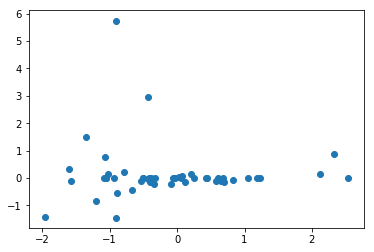

In [711]:
data = zip(enrichments, ddgs)
#data = [x for x in data if not x[1] == 0]
plt.scatter([x[0] for x in data], [x[1] for x in data])
#plt.ylim(-1.5, 1.5)

In [710]:
import scipy
scipy.stats.spearmanr([x[0] for x in data], [x[1] for x in data])

SpearmanrResult(correlation=0.07349062281877472, pvalue=0.61578458585818163)

In [696]:
enrichment

-1.9637346999999998

In [686]:
!ls Pop_Vars/Summaries

COVIDSPIKE_ACE2_D355N_1  COVIDSPIKE_ACE2_I21T_1   COVIDSPIKE_ACE2_P346S_1
COVIDSPIKE_ACE2_D38V_1	 COVIDSPIKE_ACE2_I21V_1   COVIDSPIKE_ACE2_P389H_1
COVIDSPIKE_ACE2_D509Y_1  COVIDSPIKE_ACE2_I446M_1  COVIDSPIKE_ACE2_P84T_1
COVIDSPIKE_ACE2_E23K_1	 COVIDSPIKE_ACE2_K26E_1   COVIDSPIKE_ACE2_Q102P_1
COVIDSPIKE_ACE2_E329G_1  COVIDSPIKE_ACE2_K26R_1   COVIDSPIKE_ACE2_Q388L_1
COVIDSPIKE_ACE2_E35K_1	 COVIDSPIKE_ACE2_K31R_1   COVIDSPIKE_ACE2_Q60R_1
COVIDSPIKE_ACE2_E37K_1	 COVIDSPIKE_ACE2_K68E_1   COVIDSPIKE_ACE2_R518T_1
COVIDSPIKE_ACE2_E398K_1  COVIDSPIKE_ACE2_M366T_1  COVIDSPIKE_ACE2_S19P_1
COVIDSPIKE_ACE2_F40L_1	 COVIDSPIKE_ACE2_M383T_1  COVIDSPIKE_ACE2_S511P_1
COVIDSPIKE_ACE2_F504I_1  COVIDSPIKE_ACE2_M62I_1   COVIDSPIKE_ACE2_T27A_1
COVIDSPIKE_ACE2_F504L_1  COVIDSPIKE_ACE2_M62V_1   COVIDSPIKE_ACE2_T445M_1
COVIDSPIKE_ACE2_F72V_1	 COVIDSPIKE_ACE2_M82I_1   COVIDSPIKE_ACE2_T92I_1
COVIDSPIKE_ACE2_G326E_1  COVIDSPIKE_ACE2_N290H_1  COVIDSPIKE_ACE2_Y50F_1
COVIDSPIKE_ACE2_G352V_1  COVIDSPIKE_ACE2_N33I_1   

In [12]:
import pandas as pd

In [20]:
#var_affinities = []
#with open("../Procko_ACE2_Variant_Affinity.txt", "r") as f:
#    cur = None
#    for l in f:
#        l = l.split("\t")
#        if(l[:3] != ["", "", ""]):
#            cur = l[:3]
#        else:
#            l[0] = cur[0]
#            l[1] = cur[1]
#            l[2] = cur[2]
#        var_affinities.append(l)
#var_affinities = pd.DataFrame(var_affinities[1:], columns=["Type", "Pos", "WT", "Alt", "Reads", "LogOR_High_1", "LogOR_High_2", "LogOR_Low_1", "LogOR_Low_2"])
#var_affinities.to_csv("../Procko_ACE2_Variant_Affinity.txt", sep="\t", index=None)

In [39]:
var_affinities = pd.read_csv("../Procko_ACE2_Variant_Affinity.txt", sep="\t")

In [24]:
import helper as my

In [28]:
iresA1, iresB1 = my.call("irescalc.py COVIDSPIKEACE2.pdb")

In [31]:
iresA2, iresB2 = my.call("irescalc.py SARSSPIKEACE2.pdb")

In [32]:
print iresB1
print iresB2

19,24,27,30,31,34,35,37,38,41,42,45,79,82,324,325,326,330,353,354
19,23,24,27,30,31,34,35,38,41,42,45,75,79,82,83,324,325,326,329,330,353,354,386,393


In [33]:
iresB = set([int(x) for x in iresB1.split(",")]).union([int(x) for x in iresB2.split(",")])

In [ ]:
for pos, ref, alt in tqdm_notebook(var_affinities[var_affinities["Pos"].isin(iresB)][["Pos", "WT", "Alt"]].values):
    mut = ref + str(pos) + alt
    pos, ref, alt = int(mut[1:-1]), mut[0], mut[-1]
    if(os.path.exists("Pop_Vars/Summaries/COVIDSPIKE_ACE2_{0}_1".format(mut))):
        continue
    os.system("python Mutant_ddG_Calc.py COVIDSPIKE ACE2_{0}{1}{2} COVIDSPIKEACE2.pdb 1 {1}_{2} 10 8".format(ref, pos, alt))

In [106]:
import scipy

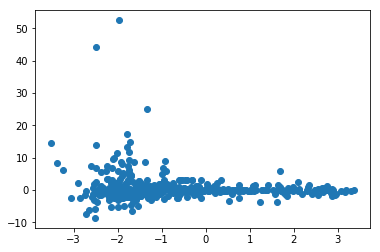

In [216]:
enrichments = []
ddgs = []
ps = []
for pos, ref, alt, e1, e2, e3, e4 in tqdm_notebook(var_affinities[var_affinities["Pos"].isin(iresB)][["Pos", "WT", "Alt", "LogOR_High_1", "LogOR_High_2", "LogOR_Low_1", "LogOR_Low_2"]].values):
    #if(not (pos, alt) in [(19, "P"), (27, "A"), (35, "K"), (37, "K"), (82, "I"), (326, "E")]):
    #    continue
    #enrichment = np.log2(np.mean([2**e1, 2**e2])#, 2**-e3, 2**-e4]))
    enrichment = np.mean([e1, e2])
    mut = ref + str(pos) + alt
    ddg = pd.read_csv("Pop_Vars/Summaries/COVIDSPIKE_ACE2_{0}_1".format(mut), sep="\t")
    ddg_std = ddg["ddG"].std()
    if(ddg_std <= 10**-5):
        ddg_std = 0
        #break
    ddg = float(ddg["ddG"].mean())
    try:
        p = scipy.stats.norm.sf(abs(ddg / ddg_std))
    except ZeroDivisionError:
        p = 1
    ps.append(p)
    #if(p > 0.05):
    #    continue
    enrichments.append(enrichment)
    ddgs.append(ddg)
    #print pos, ref, alt, enrichment, ddg
plt.scatter(enrichments, ddgs)

In [149]:
type(ddg)

float

Text(11,-3.8,'n=35 (70.00%)')

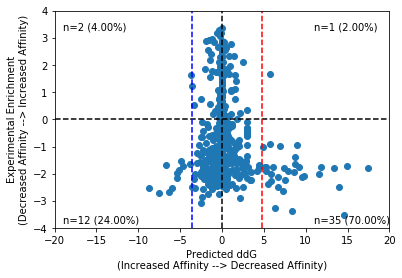

In [219]:
ddg_thresh = np.std(ddgs)
enrich_thresh = 0
data = zip(enrichments, ddgs)
#data = [x for x in data if abs(x[1]) > 1]
plt.scatter([x[1] for x in data], [x[0] for x in data], alpha=1)
#plt.ylim(-1.5, 1.5)
plt.ylim(-4, 4)
plt.xlim(-20, 20)
plt.axhline(0, linestyle="--", color="k")
#plt.axhline(enrich_thresh, linestyle="--", color="b")
#plt.axhline(-enrich_thresh, linestyle="--", color="r")
plt.axvline(0, linestyle="--", color="k")
plt.axvline(np.mean(ddgs) - ddg_thresh, linestyle="--", color="b")
plt.axvline(np.mean(ddgs) + ddg_thresh, linestyle="--", color="r")
plt.xlabel("Predicted ddG\n(Increased Affinity --> Decreased Affinity)")
plt.ylabel("Experimental Enrichment\n(Decreased Affinity --> Increased Affinity)")
total = 0
UR = 0
UL = 0
LR = 0
LL = 0
center = 0
for enrich, ddg in data:
    if(abs(ddg - np.mean(ddgs)) < ddg_thresh or abs(enrich) < enrich_thresh):
    #if(abs(enrich) < enrich_thresh or (ddg > np.mean(ddgs) - ddg_thresh and ddg < np.mean(ddgs) + ddg_thresh)):
        center += 1
        continue
    total += 1
    if(ddg > 0):
        if(enrich < 0):
            LR += 1
        else:
            UR += 1
    else:
        if(enrich > 0):
            UL += 1
        else:
            LL += 1
plt.text(-19, 3.3, "n={0} ({1:0.2f}%)".format(UL, UL / float(total) * 100))
plt.text(11, 3.3, "n={0} ({1:0.2f}%)".format(UR, UR / float(total) * 100))
plt.text(-19, -3.8, "n={0} ({1:0.2f}%)".format(LL, LL / float(total) * 100))
plt.text(11, -3.8, "n={0} ({1:0.2f}%)".format(LR, LR / float(total) * 100))
#print right, total
#print right / float(total)

Text(11,-3.8,'n=35 (70.00%)')

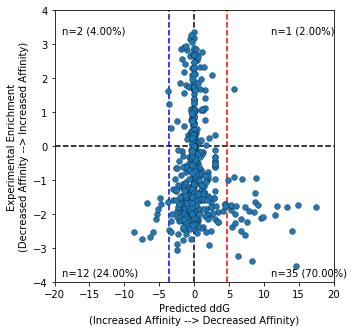

In [228]:
plt.figure(figsize=(5, 5))
ddg_thresh = np.std(ddgs)
enrich_thresh = 0
data = zip(enrichments, ddgs)
#data = [x for x in data if abs(x[1]) > 1]
plt.scatter([x[1] for x in data], [x[0] for x in data], alpha=1, edgecolor="k", linewidth=0.25, zorder=[np.sqrt(x[1]**2 + x[0]**2) for x in data])
#plt.ylim(-1.5, 1.5)
plt.ylim(-4, 4)
plt.xlim(-20, 20)
plt.axhline(0, linestyle="--", color="k")
#plt.axhline(enrich_thresh, linestyle="--", color="b")
#plt.axhline(-enrich_thresh, linestyle="--", color="r")
plt.axvline(0, linestyle="--", color="k")
plt.axvline(np.mean(ddgs) - ddg_thresh, linestyle="--", color="b")
plt.axvline(np.mean(ddgs) + ddg_thresh, linestyle="--", color="r")
plt.xlabel("Predicted ddG\n(Increased Affinity --> Decreased Affinity)")
plt.ylabel("Experimental Enrichment\n(Decreased Affinity --> Increased Affinity)")
total = 0
UR = 0
UL = 0
LR = 0
LL = 0
center = 0
for enrich, ddg in data:
    if(abs(ddg - np.mean(ddgs)) < ddg_thresh or abs(enrich) < enrich_thresh):
    #if(abs(enrich) < enrich_thresh or (ddg > np.mean(ddgs) - ddg_thresh and ddg < np.mean(ddgs) + ddg_thresh)):
        center += 1
        continue
    total += 1
    if(ddg > 0):
        if(enrich < 0):
            LR += 1
        else:
            UR += 1
    else:
        if(enrich > 0):
            UL += 1
        else:
            LL += 1
plt.text(-19, 3.3, "n={0} ({1:0.2f}%)".format(UL, UL / float(total) * 100))
plt.text(11, 3.3, "n={0} ({1:0.2f}%)".format(UR, UR / float(total) * 100))
plt.text(-19, -3.8, "n={0} ({1:0.2f}%)".format(LL, LL / float(total) * 100))
plt.text(11, -3.8, "n={0} ({1:0.2f}%)".format(LR, LR / float(total) * 100))
#print right, total
#print right / float(total)

In [253]:
tmp = pd.read_csv("../Data/ddG_Summary.txt", sep="\t")

In [254]:
tmp["z-score"] = (tmp["ddG"] - tmp["ddG"].mean()) / tmp["ddG"].std()

In [255]:
sum(tmp["z-score"].abs() >= 1)

18

In [256]:
sum(tmp["p-value"] <= 0.05)

41

In [257]:
tmp[tmp["z-score"].abs() >= 1].sort_values("p-value")

,P1,P2,WT_Score,WT_Score_Std,WT_dG,WT_dG_Std,Mut_Score,Mut_Score_Std,Mut_dG,Mut_dG_Std,ddG,ddG_Std,p-value,pdbfile,z-score
201,orf9c,Q9Y375,305.139102,0.731028,-6.359432,1.054646,389.611031,0.407221,15.366340,0.525175,-21.725772,1.105586,2.838885e-86,Data/ddG_Mutated_Structures/COVID19orf9c_Q9Y37...,-3.299163
162,orf6,P52948,234.605440,0.329094,13.610992,0.395742,261.274887,0.207725,8.814703,0.256257,4.796290,0.411746,1.165481e-31,Data/ddG_Mutated_Structures/COVID19orf6_P52948...,1.005416
176,orf9b,Q9UKA9,114.311969,0.514208,-0.001801,0.792949,130.131997,0.503388,9.442128,0.650223,-9.443929,0.968432,9.063762e-23,Data/ddG_Mutated_Structures/COVID19orf9b_Q9UKA...,-1.305797
179,orf9c,O43292,1238.304145,0.580586,-3.729355,0.866276,1307.455964,0.512941,5.585817,0.544179,-9.315172,1.023123,4.327438e-20,Data/ddG_Mutated_Structures/COVID19orf9c_O4329...,-1.284900
170,orf9b,O94826,245.013533,0.595247,1.399465,0.713955,262.823798,0.910632,12.694544,1.050349,-11.295079,1.291835,1.130639e-18,Data/ddG_Mutated_Structures/COVID19orf9b_O9482...,-1.606242
202,orf9c,Q9Y3A6,607.135625,0.514205,-0.239288,1.038316,684.327194,1.575699,20.850724,2.166253,-21.090012,2.416274,1.292403e-18,Data/ddG_Mutated_Structures/COVID19orf9c_Q9Y3A...,-3.195978
181,orf9c,P33527,294.109389,0.856267,-0.470424,0.997251,361.200949,0.375824,7.696855,0.561922,-8.167280,1.154098,7.378097e-13,Data/ddG_Mutated_Structures/COVID19orf9c_P3352...,-1.098595
184,orf9c,Q2PZI1,348.417904,0.590562,-1.077319,1.098407,423.004620,1.606909,10.181490,2.106636,-11.258809,2.364507,9.603754e-07,Data/ddG_Mutated_Structures/COVID19orf9c_Q2PZI...,-1.600356
188,orf9c,Q7Z2K6,256.444204,0.319012,-1.606500,0.847331,317.435663,1.279545,7.523617,2.130109,-9.130117,2.229695,2.112825e-05,Data/ddG_Mutated_Structures/COVID19orf9c_Q7Z2K...,-1.254865
190,orf9c,Q86VR2,381.747575,0.439669,0.910780,0.722876,444.841793,1.676228,10.485695,2.331640,-9.574915,2.367712,2.627885e-05,Data/ddG_Mutated_Structures/COVID19orf9c_Q86VR...,-1.327057


[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Text(0,0.5,'ddG p-value\n(among other trials same interaction)')

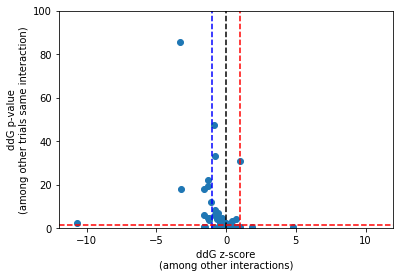

In [274]:
plt.scatter(tmp["z-score"], -np.log10(tmp["p-value"]))
plt.ylim(0, 100)
plt.xlim(-12, 12)
plt.axvline(0, color="k", linestyle="--")
plt.axvline(-1, color="blue", linestyle="--")
plt.axvline(1, color="red", linestyle="--")
plt.axhline(-np.log10(0.05), color="r", linestyle="--")
plt.xlabel("ddG z-score\n(among other interactions)")
plt.ylabel("ddG p-value\n(among other trials same interaction)")

In [263]:
-np.log10(0.05)

1.3010299956639813

In [558]:
ddg_singles = []
for f in tqdm_notebook(glob.glob("../Data/ddG_Single_Mutants/Summaries/*Mean*")):
    tmp = pd.read_csv(f, sep="\t")
    p1, p2 = os.path.basename(f).split("_")[:2]
    tmp2 = []
    for i in range(len(tmp)):
        row = tmp.ix[i]
        for mut in "ACEDGFIHKMLNQPSRTWVY":
            tmp2.append([p1, p2] + list(row[["Chain", "Ref", "Pos"]]) + [mut, row["ddG_{0}_avg".format(mut)], row["ddG_{0}_std".format(mut)]])
    tmp2 = pd.DataFrame(tmp2, columns=["P1", "P2", "Chain", "Ref", "Pos", "Alt", "ddG", "std"])
    
    def do(ddg, std):
        try:
            p = scipy.stats.norm.sf(abs(ddg / std))
        except ZeroDivisionError:
            p = 1
        return p
    # FUNCTION END
    tmp2["p-value"] = tmp2[["ddG", "std"]].apply(lambda x: do(*x), axis=1)
    
    for chain in ["A", "B"]:
        ddg = tmp2[tmp2["Chain"] == chain]["ddG"].mean()
        std = tmp2[tmp2["Chain"] == chain]["ddG"].std()
        tmp2.ix[tmp2["Chain"] == chain, "z-score"] = tmp2[tmp2["Chain"] == chain]["ddG"].map(lambda x: (x - ddg) / std)

        for mut in "ACEDGFIHKMLNQPSRTWVY":
            ddg = tmp2[(tmp2["Chain"] == chain)&(tmp2["Alt"] == mut)]["ddG"].mean()
            std = tmp2[(tmp2["Chain"] == chain)&(tmp2["Alt"] == mut)]["ddG"].std()
            tmp2.ix[(tmp2["Chain"] == chain)&(tmp2["Alt"] == mut), "z-score (same AA)"] = tmp2[(tmp2["Chain"] == chain)&(tmp2["Alt"] == mut)]["ddG"].map(lambda x: (x - ddg) / std)
    
    ddg_singles.append(tmp2)

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [559]:
pd.read_csv(f, sep="\t")

,Chain,Ref,Pos,ddG_A_avg,ddG_A_std,ddG_A_z,ddG_C_avg,ddG_C_std,ddG_C_z,ddG_E_avg,ddG_E_std,ddG_E_z,ddG_D_avg,ddG_D_std,ddG_D_z,ddG_G_avg,ddG_G_std,ddG_G_z,ddG_F_avg,ddG_F_std,ddG_F_z,ddG_I_avg,ddG_I_std,ddG_I_z,ddG_H_avg,ddG_H_std,ddG_H_z,ddG_K_avg,ddG_K_std,ddG_K_z,ddG_M_avg,ddG_M_std,ddG_M_z,ddG_L_avg,ddG_L_std,ddG_L_z,ddG_N_avg,ddG_N_std,ddG_N_z,ddG_Q_avg,ddG_Q_std,ddG_Q_z,ddG_P_avg,ddG_P_std,ddG_P_z,ddG_S_avg,ddG_S_std,ddG_S_z,ddG_R_avg,ddG_R_std,ddG_R_z,ddG_T_avg,ddG_T_std,ddG_T_z,ddG_W_avg,ddG_W_std,ddG_W_z,ddG_V_avg,ddG_V_std,ddG_V_z,ddG_Y_avg,ddG_Y_std,ddG_Y_z
0,A,M,1,-0.314798,7.099768e-01,-0.399913,-0.172158,4.978355e-01,-0.179522,-0.292290,3.504583e-01,-0.966063,8.269809,5.912427e-02,4.131317,0.052312,6.855516e-01,-0.198118,0.126435,4.434320e-02,-0.207376,22.747656,4.431672e-02,5.337202,-0.198204,1.876383e-01,-0.372870,-0.066032,1.799166e-01,-0.445012,0.034980,5.724705e-02,0.207927,9.533410,4.103166e-02,1.808360,21.997656,0.000000e+00,5.343221,-0.466337,2.873235e-01,-0.989706,0.723400,6.470469e-02,0.045777,0.035260,1.156404e-01,-0.336377,-0.108691,1.463820e-01,-0.569771,0.686121,1.094961e-01,0.630983,-0.005451,1.491836e-01,-0.224855,-0.022334,7.473667e-02,-0.007717,-0.055246,2.487963e-01,-0.311643
1,A,L,2,-0.006334,2.654254e-01,-0.057127,0.452504,3.003407e-01,0.547426,0.869000,3.668982e-01,-0.083675,0.773771,3.071858e-01,-0.132108,0.687224,2.868557e-01,0.313475,0.332466,5.484655e-01,-0.191373,-0.759169,2.452850e-01,-0.398926,0.699110,3.239965e-01,-0.142016,0.956614,4.249818e-01,-0.246593,-0.141554,1.847626e-01,0.050804,-0.042358,3.059647e-01,-0.188444,0.551243,3.177085e-01,-0.141259,0.273807,4.947575e-01,-0.245429,0.623892,7.069158e-01,-0.010177,0.808896,2.539562e-01,0.623609,0.859307,3.254074e-01,-0.290684,0.366501,3.068337e-01,0.190609,-0.570740,4.867730e-01,-0.252768,-0.254240,3.117698e-01,-0.254328,0.125556,4.876603e-01,-0.303468
2,A,Q,3,0.506444,2.371479e-01,0.512706,0.796636,4.655757e-01,0.947908,1.426149,2.798638e-01,0.339665,0.369325,4.028882e-01,-0.362139,-0.212125,2.510061e-01,-0.411194,7.107001,2.532955e-01,0.334820,-0.048857,3.074673e-01,-0.225596,8.268115,3.492556e-01,1.805277,4.637513,2.425576e-01,0.467593,1.679848,3.017697e-01,1.671933,6.587636,3.805063e-01,1.194087,0.813758,2.723642e-01,-0.074126,-0.030535,3.516965e-01,-0.551471,6.249904,2.523159e-01,3.153412,-0.513016,4.000909e-01,-1.016721,2.597619,2.844099e-01,0.210493,0.298415,3.360104e-01,0.096799,112.680548,2.842503e-01,5.339523,1.379639,3.509755e-01,1.483153,11.346575,2.456252e-01,0.203857
3,A,C,5,-0.169138,2.466317e-01,-0.238045,-0.171168,1.793840e-01,-0.178369,0.336094,3.790876e-01,-0.488596,0.438390,1.747851e-01,-0.322858,0.191591,2.686985e-01,-0.085891,0.085728,4.194029e-01,-0.210538,0.550032,3.946768e-01,-0.079455,0.077391,3.543121e-01,-0.301967,-0.173173,3.839574e-01,-0.465799,-0.025580,3.431147e-01,0.154026,0.246089,3.276381e-01,-0.128295,-0.065263,2.724695e-01,-0.298918,-0.048955,4.331395e-01,-0.569994,6.262813,1.944284e-01,3.160671,0.243632,1.938468e-01,-0.077813,0.217113,1.706893e-01,-0.475837,0.374189,2.285446e-01,0.201201,-0.943250,3.603701e-01,-0.271163,0.065887,1.582215e-01,0.086098,1.006699,4.694811e-01,-0.263630
4,A,Y,6,0.351843,1.511355e-01,0.340903,-0.682146,3.441268e-01,-0.773017,0.550631,1.122734e-01,-0.325583,0.093408,1.446336e-01,-0.519069,0.307069,1.613797e-01,0.007158,-0.191494,7.616612e-02,-0.232070,-0.750590,3.484504e-01,-0.396833,0.039418,1.705464e-01,-0.311736,0.799523,3.597833e-01,-0.277072,-0.033915,4.570253e-01,0.146607,-1.957579,3.116357e-01,-0.587819,-0.090760,2.354090e-01,-0.305438,0.227518,2.571179e-01,-0.291977,-0.536780,9.138936e-02,-0.662840,-0.021793,1.710724e-01,-0.407173,0.234541,2.381910e-01,-0.470813,-0.085885,1.276143e-01,-0.432693,-0.377914,2.616414e-01,-0.243247,-0.942399,1.477603e-01,-0.986122,-0.098251,1.444620e-01,-0.313587
5,A,L,9,0.190471,1.950583e-01,0.161576,-0.273647,1.355264e-01,-0.297629,0.410747,1.074493e-01,-0.431871,0.437816,1.819890e-01,-0.323184,0.149498,1.757742e-01,-0.119808,0.1828

In [560]:
ddg_singles = pd.concat(ddg_singles)

In [561]:
pop_vars = pd.read_csv("../Data/Pop_Vars.txt", sep="\t")
pop_vars = set(pop_vars[["UniProt", "AA_Ref", "AA_Pos", "AA_Alt"]].apply(tuple, axis=1).values)

In [562]:
ddg_singles["is_pop_var"] = ddg_singles[["Chain", "P2", "Ref", "Pos", "Alt"]].apply(lambda x: x[0] == "B" and tuple(x[1:]) in pop_vars, axis=1)

In [563]:
ddg_singles["is_pop_var"].sum()

2241

In [564]:
#exposure_mask = ddg_singles["p-value"] <= 0.05
#exposure_mask = ddg_singles["z-score"].abs() >= 1
exposure_mask = ddg_singles["z-score (same AA)"].abs() >= 1
case_mask = ddg_singles["is_pop_var"] == True

my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True)

               Case  Non-Case
Exposed       358.0   30067.0
Non-Exposed  1883.0  148232.0


(-0.093397412419042175,
 0.070614135158923244,
 -0.25740895999700758,
 0.26437339193814458)

In [566]:
ddg_singles.to_csv("../Data/ddG_Single_Mutants/Hotspot_Scored_Mutants.txt", sep="\t", index=None)

In [567]:
ddg_singles[ddg_singles["is_pop_var"]&(ddg_singles["P2"] == "Q9Y375")]

,P1,P2,Chain,Ref,Pos,Alt,ddG,std,p-value,z-score,z-score (same AA),is_pop_var
382,COVID19orf9c,Q9Y375,B,Q,120,E,0.116907,0.000000e+00,1.000000e+00,-0.192058,-0.515284,True
404,COVID19orf9c,Q9Y375,B,A,121,G,0.012869,1.828559e-18,0.000000e+00,-0.201645,-0.250269,True
459,COVID19orf9c,Q9Y375,B,F,127,Y,0.092409,1.462847e-17,0.000000e+00,-0.194315,-0.292314,True
486,COVID19orf9c,Q9Y375,B,T,139,I,0.288204,4.533575e-01,2.624823e-01,-0.176274,-0.188257,True
522,COVID19orf9c,Q9Y375,B,D,141,E,0.227623,0.000000e+00,1.000000e+00,-0.181856,-0.487449,True
569,COVID19orf9c,Q9Y375,B,T,143,M,-0.605341,4.351796e-01,8.211044e-02,-0.258608,-0.445968,True
603,COVID19orf9c,Q9Y375,B,G,146,D,8.434394,3.811970e-02,0.000000e+00,0.574343,2.453690,True
626,COVID19orf9c,Q9Y375,B,S,148,I,-2.780528,1.327683e-01,1.093481e-97,-0.459037,-0.952003,True
707,COVID19orf9c,Q9Y375,B,Y,164,H,0.003665,5.904516e-03,2.674180e-01,-0.202493,-0.538935,True


In [568]:
ddg_singles[ddg_singles["is_pop_var"]&(ddg_singles["z-score (same AA)"].abs() >= 1)&(ddg_singles["p-value"] <= 0.05)].sort_values("z-score (same AA)")

,P1,P2,Chain,Ref,Pos,Alt,ddG,std,p-value,z-score,z-score (same AA),is_pop_var
574,COVID19nsp4,Q9Y5J7,B,F,14,S,-25.325923,3.744889e-15,0.000000e+00,-1.828921,-4.666787,True
381,COVID19nsp7,O00116,B,R,317,C,-5.692957,7.586830e-02,0.000000e+00,-1.248510,-3.970179,True
804,COVID19nsp13,Q96SN8,B,S,1500,G,-5.778734,9.362223e-16,0.000000e+00,-4.296583,-3.800725,True
423,COVID19orf8,Q6UW63,B,Y,49,D,-27.759369,3.079153e-01,0.000000e+00,-1.424525,-3.569124,True
384,COVID19nsp7,O00116,B,R,317,G,-6.282468,6.194178e-02,0.000000e+00,-1.357257,-3.519546,True
441,COVID19nsp8,O76094,B,R,121,C,-5.162482,2.036528e-01,4.558490e-142,-1.203603,-3.481002,True
801,COVID19orf9b,O43633,B,R,74,C,-7.346200,3.738048e+00,2.469264e-02,-1.746272,-3.373893,True
640,COVID19nsp13,Q04726,B,G,139,A,-2.638178,4.681111e-16,0.000000e+00,-0.799437,-3.205588,True
391,COVID19nsp13,Q8N8E3,B,K,466,N,-5.141326,1.692592e-02,0.000000e+00,-2.654907,-3.195460,True
825,COVID19orf9c,Q5BJF2,B,L,157,F,-5.891637,3.704408e-02,0.000000e+00,-3.590998,-3.103876,True


[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


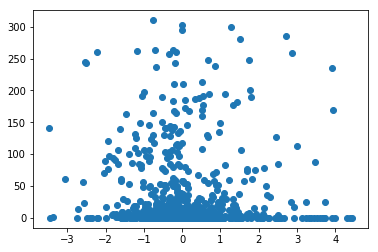

In [569]:
plt.scatter(ddg_singles[ddg_singles["is_pop_var"]]["z-score (same AA)"], ddg_singles[ddg_singles["is_pop_var"]]["p-value"].map(lambda x: -np.log10(x)))

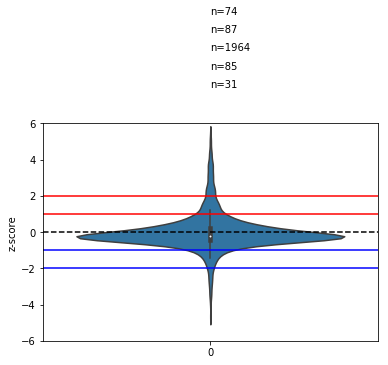

In [570]:
import seaborn as sn
sn.violinplot(data=ddg_singles[ddg_singles["is_pop_var"]]["z-score (same AA)"].values)
plt.axhline(0, linestyle="--", color="k")
plt.axhline(1, linestyle="-", color="r")
plt.axhline(-1, linestyle="-", color="b")
plt.axhline(2, linestyle="-", color="r")
plt.axhline(-2, linestyle="-", color="b")
plt.ylim(-6, 6)
plt.ylabel("z-score")
plt.text(s="n={0}".format(ddg_singles[ddg_singles["is_pop_var"]&(ddg_singles["p-value"] <= 0.05)]["z-score (same AA)"].map(lambda x: x >= 2).sum()), x=0, y=12)
plt.text(s="n={0}".format(ddg_singles[ddg_singles["is_pop_var"]&(ddg_singles["p-value"] <= 0.05)]["z-score (same AA)"].map(lambda x: 2 > x >= 1).sum()), x=0, y=11)
plt.text(s="n={0}".format(ddg_singles[ddg_singles["is_pop_var"]&(ddg_singles["p-value"] <= 0.05)]["z-score (same AA)"].map(lambda x: -1 < x < 1).sum() + len(ddg_singles[ddg_singles["is_pop_var"]&(ddg_singles["p-value"] > 0.05)])), x=0, y=10)
plt.text(s="n={0}".format(ddg_singles[ddg_singles["is_pop_var"]&(ddg_singles["p-value"] <= 0.05)]["z-score (same AA)"].map(lambda x: -1 >= x > -2).sum()), x=0, y=9)
plt.text(s="n={0}".format(ddg_singles[ddg_singles["is_pop_var"]&(ddg_singles["p-value"] <= 0.05)]["z-score (same AA)"].map(lambda x: x <= -2).sum()), x=0, y=8)
plt.savefig("../Figures/Figure_4/Pop_Var_Normalized_ddG.svg")

In [393]:
96 + 101 + 126 + 33

356

In [573]:
len(ddg_singles[ddg_singles["is_pop_var"]])

2241

In [571]:
ddg_singles[ddg_singles["is_pop_var"]].to_csv("../Table_8_Intermediate.txt", sep="\t", index=None)

In [572]:
ddg_singles[ddg_singles["is_pop_var"]]

,P1,P2,Chain,Ref,Pos,Alt,ddG,std,p-value,z-score,z-score (same AA),is_pop_var
215,COVID19nsp2,Q5T1M5,B,W,207,R,1.185242,0.000000e+00,1.000000e+00,-0.164278,-0.375781,True
228,COVID19nsp2,Q5T1M5,B,N,211,K,-0.100607,0.000000e+00,1.000000e+00,-0.237257,-0.521112,True
252,COVID19nsp2,Q5T1M5,B,H,212,Q,-0.205321,0.000000e+00,1.000000e+00,-0.243200,-0.869704,True
308,COVID19nsp2,Q5T1M5,B,N,223,K,24.778987,4.870398e-01,0.000000e+00,1.174798,2.492674,True
324,COVID19nsp2,Q5T1M5,B,D,225,G,-0.431307,0.000000e+00,1.000000e+00,-0.256026,0.402372,True
331,COVID19nsp2,Q5T1M5,B,D,225,N,-0.154638,5.083329e-02,1.174800e-03,-0.240323,-0.778596,True
348,COVID19nsp2,Q5T1M5,B,E,283,K,0.370721,1.071087e-01,2.689178e-04,-0.210506,-0.464018,True
295,COVID19orf8,Q9Y4L1,B,Q,132,R,0.163433,2.925695e-17,0.000000e+00,-0.141260,-0.270687,True
300,COVID19orf8,Q9Y4L1,B,V,134,A,0.155789,2.007394e-02,4.221298e-15,-0.141684,0.519363,True
309,COVID19orf8,Q9Y4L1,B,V,134,M,1.010104,1.544183e-01,3.048280e-11,-0.094252,0.595484,True


In [478]:
lines = []
source_df = my.pdb2df("../Data/ddG_Mutated_Structures/All_Structures/COVID19SPIKE_ACE2/COVIDSPIKE_ACE2_1_SARS_Muts_1WT_Complex.pdb")
with open("../Data/ddG_Mutated_Structures/All_Structures/COVID19SPIKE_ACE2/COVIDSPIKE_ACE2_1_SARS_Muts_1WT_Complex.pdb") as f:
    skip = True
    for l in f:
        if(skip and not l[:4] == "pose"):
            continue
        else:
            skip = False
        lines.append(l.split())
a = pd.DataFrame(lines[:-2], columns="label fa_atr fa_rep fa_sol hbond_bb_sc hbond_sc total".split())
for col in a:
    if(not col == "label"):
        a[col] = a[col].astype(float)

tmp = [[np.nan, np.nan, np.nan]] + source_df.drop_duplicates(["Chain", "Residue ID", "Residue Name"])[["Chain", "Residue ID", "Residue Name"]].apply(lambda x: list(x), axis=1).to_list()
a["Chain"] = [x[0] for x in tmp]
a["Residue ID"] = [x[1] for x in tmp]
a["Residue Name"] = [x[2] for x in tmp]
a = a[["Chain", "Residue ID", "Residue Name", "fa_atr", "fa_rep", "fa_sol", "hbond_bb_sc", "hbond_sc", "total"]].set_index(["Chain", "Residue ID", "Residue Name"])

In [479]:
lines = []
source_df = my.pdb2df("../Data/ddG_Mutated_Structures/All_Structures/COVID19SPIKE_ACE2/COVIDSPIKE_ACE2_1_SARS_Muts_1WT_Complex.pdb")
with open("../Data/ddG_Mutated_Structures/All_Structures/COVID19SPIKE_ACE2/COVIDSPIKE_ACE2_1_SARS_Muts_1WT_Separate.pdb") as f:
    skip = True
    for l in f:
        if(skip and not l[:4] == "pose"):
            continue
        else:
            skip = False
        lines.append(l.split())
b = pd.DataFrame(lines[:-2], columns="label fa_atr fa_rep fa_sol hbond_bb_sc hbond_sc total".split())
for col in b:
    if(not col == "label"):
        b[col] = b[col].astype(float)

tmp = [[np.nan, np.nan, np.nan]] + source_df.drop_duplicates(["Chain", "Residue ID", "Residue Name"])[["Chain", "Residue ID", "Residue Name"]].apply(lambda x: list(x), axis=1).to_list()
b["Chain"] = [x[0] for x in tmp]
b["Residue ID"] = [x[1] for x in tmp]
b["Residue Name"] = [x[2] for x in tmp]
b = b[["Chain", "Residue ID", "Residue Name", "fa_atr", "fa_rep", "fa_sol", "hbond_bb_sc", "hbond_sc", "total"]].set_index(["Chain", "Residue ID", "Residue Name"])

In [486]:
tmp1 = a - b
tmp1[tmp1["fa_sol"].abs() >= 0.5]

fa_atr   fa_rep    fa_sol  hbond_bb_sc  \
Chain Residue ID Residue Name                                             
NaN   NaN        NaN          -29.40000  5.19300  42.39000     -0.05990   
B     24.0       GLN           -0.83544 -0.45553   1.81691     -0.08389   
      26.0       LYS           -0.10327  0.00521   0.70351      0.00000   
      27.0       THR           -0.54032 -0.24574   0.52592      0.00000   
      28.0       PHE           -0.38941  0.04864   0.60885      0.00000   
      30.0       ASP           -0.82792  0.27230   1.55417      0.00000   
      31.0       LYS           -1.26321  0.09968   1.00058      0.00000   
      34.0       HIS           -1.57601  0.46122   1.62180      0.00000   
      35.0       GLU           -0.22826 -0.00021   1.28250      0.00000   
      37.0       GLU           -0.34097  0.31702   0.80452     -0.00619   
      38.0       ASP           -0.30904  0.00152   1.40518      0.00000   
      41.0       TYR           -0.92689  0.12556   2.24205      0.00000   
      83.0       TYR           -0.71455 -0.17569   0.74016     -0.00017   
      353.0      LYS           -2.24767  0.50522   3.94086     -0.00619   
      354.0      GLY           -0.62839  0.03525   0.80875      0.00000   
      355.0      ASP           -0.47132  0.00050   1.36885      0.00000   
A     439.0      ASN           -0.40150  0.03882   0.56012      0.16773   
      443.0      SER           -0.22606  0.02823   0.78307      0.14632   
      448.0      ASN            0.18253 -0.05060  -0.73044      0.01937   
      449.0      TYR           -0.12650  0.00152   0.60062      0.00000   
      487.0      ASN           -1.11374  0.05923   2.03429      0.00000   
      489.0      TYR           -1.51617  0.32309   1.01910      0.00000   
      493.0      GLN           -0.33872 -0.06238   1.21821     -0.06435   
      494.0      SER           -0.22100  0.03633   0.71159     -0.06435   
      496.0      GLY           -0.10840  0.00000   0.88220      0.00000   
      498.0      GLN           -1.10034  0.90841   1.57524     -0.12689   
      500.0      THR           -1.13099  0.01159   3.11917      0.00000   
      501.0      ASN           -1.19244  0.13738   2.53819     -0.15544   
      502.0      GLY           -0.55362  0.00743   1.11435      0.00000   
      505.0      TYR           -1.61061  0.33640   1.40352      0.00000   

                               hbond_sc     total  
Chain Residue ID Residue Name                      
NaN   NaN        NaN           -5.09850  13.03100  
B     24.0       GLN            0.06459   0.50665  
      26.0       LYS            0.00000   0.60547  
      27.0       THR            0.00000  -0.26015  
      28.0       PHE            0.00000   0.26808  
      30.0       ASP            0.00000   0.99854  
      31.0       LYS            0.00000  -0.16295  
      34.0       HIS           -0.50180   0.00520  
      35.0       GLU           -0.00046   1.05357  
      37.0       GLU           -0.04940   0.72496  
      38.0       ASP           -0.53649   0.56117  
      41.0       TYR           -0.44855   0.99217  
      83.0       TYR           -0.44351  -0.59377  
      353.0      LYS            0.00000   2.19222  
      354.0      GLY            0.00000   0.21561  
      355.0      ASP           -0.33931   0.55871  
A     439.0      ASN           -0.58899  -0.22380  
      443.0      SER           -0.58899   0.14258  
      448.0      ASN            0.46455  -0.11459  
      449.0      TYR           -0.53649  -0.06085  
      487.0      ASN           -0.65777   0.32201  
      489.0      TYR            0.00000  -0.17398  
      493.0      GLN           -0.00046   0.75230  
      494.0      SER            0.00000   0.46257  
      496.0      GLY            0.00000   0.77380  
      498.0      GLN            0.00000   1.25641  
      500.0      THR           -0.26150   1.73827  
      501.0      ASN            0.00000   1.32770  
      502.0      GLY            0.00000   0.56816  
      505.0      TYR

In [481]:
lines = []
source_df = my.pdb2df("../Data/ddG_Mutated_Structures/All_Structures/COVID19SPIKE_ACE2/SARSSPIKE_ACE2_1_SARS_Muts_1WT_Complex.pdb")
with open("../Data/ddG_Mutated_Structures/All_Structures/COVID19SPIKE_ACE2/SARSSPIKE_ACE2_1_SARS_Muts_1WT_Complex.pdb") as f:
    skip = True
    for l in f:
        if(skip and not l[:4] == "pose"):
            continue
        else:
            skip = False
        lines.append(l.split())
c = pd.DataFrame(lines[:-2], columns="label fa_atr fa_rep fa_sol hbond_bb_sc hbond_sc total".split())
for col in c:
    if(not col == "label"):
        c[col] = c[col].astype(float)

tmp = [[np.nan, np.nan, np.nan]] + source_df.drop_duplicates(["Chain", "Residue ID", "Residue Name"])[["Chain", "Residue ID", "Residue Name"]].apply(lambda x: list(x), axis=1).to_list()
c["Chain"] = [x[0] for x in tmp]
c["Residue ID"] = [x[1] for x in tmp]
c["Residue Name"] = [x[2] for x in tmp]
c = c[["Chain", "Residue ID", "Residue Name", "fa_atr", "fa_rep", "fa_sol", "hbond_bb_sc", "hbond_sc", "total"]].set_index(["Chain", "Residue ID", "Residue Name"])

In [482]:
lines = []
source_df = my.pdb2df("../Data/ddG_Mutated_Structures/All_Structures/COVID19SPIKE_ACE2/SARSSPIKE_ACE2_1_SARS_Muts_1WT_Complex.pdb")
with open("../Data/ddG_Mutated_Structures/All_Structures/COVID19SPIKE_ACE2/SARSSPIKE_ACE2_1_SARS_Muts_1WT_Separate.pdb") as f:
    skip = True
    for l in f:
        if(skip and not l[:4] == "pose"):
            continue
        else:
            skip = False
        lines.append(l.split())
d = pd.DataFrame(lines[:-2], columns="label fa_atr fa_rep fa_sol hbond_bb_sc hbond_sc total".split())
for col in d:
    if(not col == "label"):
        d[col] = d[col].astype(float)

tmp = [[np.nan, np.nan, np.nan]] + source_df.drop_duplicates(["Chain", "Residue ID", "Residue Name"])[["Chain", "Residue ID", "Residue Name"]].apply(lambda x: list(x), axis=1).to_list()
d["Chain"] = [x[0] for x in tmp]
d["Residue ID"] = [x[1] for x in tmp]
d["Residue Name"] = [x[2] for x in tmp]
d = d[["Chain", "Residue ID", "Residue Name", "fa_atr", "fa_rep", "fa_sol", "hbond_bb_sc", "hbond_sc", "total"]].set_index(["Chain", "Residue ID", "Residue Name"])

In [485]:
tmp2 = c - d
tmp2[tmp2["fa_sol"].abs() >= 0.5]

fa_atr   fa_rep    fa_sol  hbond_bb_sc  \
Chain Residue ID Residue Name                                             
NaN   NaN        NaN          -23.13000  1.75000  50.16000     -0.30480   
A     390.0      LYS            0.06791 -0.20921  -0.51307      0.00000   
      424.0      ASN            0.43072  0.21435  -1.35202      0.22838   
      426.0      ARG            0.77051  0.01940  -0.94660      0.22838   
      440.0      TYR           -0.25397  0.03006   0.65241      0.00000   
      442.0      TYR           -0.58800  0.03768   0.59680     -0.00414   
      461.0      SER           -0.08102  0.01244   0.59205     -0.09437   
      462.0      PRO           -0.62602 -0.02895   1.20413     -0.00065   
      463.0      ASP           -0.82573  0.08978   3.44027     -0.07709   
      464.0      GLY           -0.14071  0.00000   0.51347      0.00000   
      465.0      LYS           -0.47816  0.05164   2.03342     -0.17145   
      473.0      ASN           -0.74788  0.00545   1.74891      0.00000   
      475.0      TYR           -1.52774  0.24750   0.98790      0.00000   
      479.0      ASN           -0.61293  0.03488   1.28596      0.00000   
      480.0      ASP           -0.10687 -0.00002   0.91740      0.00000   
      482.0      GLY           -0.21855  0.01272   0.73214      0.00000   
      486.0      THR           -1.35540  0.42252   3.45936      0.00000   
      487.0      THR           -0.62320 -0.35063   1.23623     -0.14270   
      488.0      GLY           -0.38015 -0.00592   0.89475      0.03491   
      490.0      GLY           -0.21903  0.87358   0.86072      0.00000   
      491.0      TYR           -0.61106 -0.33486   1.41645     -0.17761   
      494.0      TYR           -0.34236  0.30125   0.64746      0.00000   
B     19.0       SER           -0.87403  0.06788   2.77095     -0.00065   
      23.0       GLU           -0.13641 -0.00759   0.50552      0.00000   
      24.0       GLN           -0.67976 -0.18884   1.93691      0.00000   
      26.0       LYS           -0.17348  0.00146   0.81648      0.00000   
      27.0       THR           -0.77608 -0.15828   0.90418      0.00000   
      28.0       PHE           -0.43799  0.02908   0.75459      0.00000   
      30.0       ASP           -0.62826  0.03678   1.30019      0.00000   
      31.0       LYS           -1.11046  0.11525   1.39118      0.00000   
      34.0       HIS           -0.64171  0.04606   1.37016      0.00000   
      35.0       GLU           -0.16916  0.00002   1.11990      0.00000   
      37.0       GLU           -0.23479  0.03484   0.51026     -0.04324   
      38.0       ASP           -0.12599  0.00000   0.63276      0.00000   
      83.0       TYR            0.15258 -0.34189   1.00458      0.00000   
      330.0      ASN           -0.96891  0.35250   2.46473      0.00000   
      353.0      LYS           -1.20401  0.01188   2.25912     -0.04324   
      355.0      ASP           -1.11310  0.13039   4.19230      0.00000   
      356.0      PHE           -0.10777  0.00040   0.55359      0.00000   
      357.0      ARG           -0.41810  0.11454   1.98610      0.00000   

                               hbond_sc     total  
Chain Residue ID Residue Name                      
NaN   NaN        NaN           -1.93760  26.54400  
A     390.0      LYS            0.00000  -0.65437  
      424.0      ASN            0.46879  -0.00978  
      426.0      ARG           -0.60282  -0.53114  
      440.0      TYR           -0.29156   0.13695  
      442.0      TYR            0.00000   0.04233  
      461.0      SER            0.00000   0.42910  
      462.0      PRO            0.00000   0.54851  
      463.0      ASP            0.00000   2.62725  
      464.0      GLY            0.00000   0.37276  
      465.0      LYS            0.00000   1.43544  
      473.0      ASN            0.00000   1.00647  
      475.0      TYR            0.00000  -0.29233  
      479.0      ASN           -0.29156   0.41636  
      480.0      ASP            0.00000   0.81051 

In [445]:
(c["label"] != d["label"]).sum()

1

In [446]:
c[c["label"] != d["label"]]

,label,fa_atr,fa_rep,fa_sol,hbond_bb_sc,hbond_sc,total
201,HIS_D_201,-1.94028,0.03745,3.94985,0.0,0.0,2.04701


In [448]:
d[c["label"] != d["label"]]

,label,fa_atr,fa_rep,fa_sol,hbond_bb_sc,hbond_sc,total
201,HIS_201,-1.78062,0.03911,3.80772,0.0,0.0,2.06622


In [491]:
tmp1

fa_atr   fa_rep    fa_sol  hbond_bb_sc  \
Chain Residue ID Residue Name                                             
NaN   NaN        NaN          -29.40000  5.19300  42.39000     -0.05990   
B     19.0       SER           -0.09275 -0.00025   0.11010     -0.08389   
      20.0       THR           -0.10976  0.08619   0.20702     -0.01954   
      21.0       ILE           -0.30958 -0.00076   0.33397      0.00000   
      22.0       GLU           -0.00187  0.00000   0.00625      0.00000   
      23.0       GLU            0.03488 -0.06414   0.39260     -0.01954   
      24.0       GLN           -0.83544 -0.45553   1.81691     -0.08389   
      25.0       ALA            0.06024  0.00015   0.00788      0.00000   
      26.0       LYS           -0.10327  0.00521   0.70351      0.00000   
      27.0       THR           -0.54032 -0.24574   0.52592      0.00000   
      28.0       PHE           -0.38941  0.04864   0.60885      0.00000   
      29.0       LEU           -0.03675  0.00000   0.15096      0.00000   
      30.0       ASP           -0.82792  0.27230   1.55417      0.00000   
      31.0       LYS           -1.26321  0.09968   1.00058      0.00000   
      32.0       PHE           -0.01261 -0.00007   0.00214      0.00000   
      33.0       ASN           -0.16920  0.00534   0.08897      0.00000   
      34.0       HIS           -1.57601  0.46122   1.62180      0.00000   
      35.0       GLU           -0.22826 -0.00021   1.28250      0.00000   
      36.0       ALA            0.00008  0.00000   0.00000      0.00000   
      37.0       GLU           -0.34097  0.31702   0.80452     -0.00619   
      38.0       ASP           -0.30904  0.00152   1.40518      0.00000   
      39.0       LEU           -0.05207  0.00000   0.05845      0.00000   
      40.0       PHE           -0.00010  0.00000   0.00000      0.00000   
      41.0       TYR           -0.92689  0.12556   2.24205      0.00000   
      42.0       GLN           -0.04487  0.00169   0.14798      0.00000   
      43.0       SER            0.00631 -0.00001  -0.02143      0.00000   
      44.0       SER            0.00005  0.00000   0.00000      0.00000   
      45.0       LEU           -0.32675  0.81604   0.17084      0.00000   
      46.0       ALA            0.02941  0.00000  -0.04437      0.00000   
      47.0       SER            0.00000  0.00000   0.00000      0.00000   
...                                 ...      ...       ...          ...   
A     498.0      GLN           -1.10034  0.90841   1.57524     -0.12689   
      499.0      PRO           -0.22181  0.02448   0.28634     -0.05256   
      500.0      THR           -1.13099  0.01159   3.11917      0.00000   
      501.0      ASN           -1.19244  0.13738   2.53819     -0.15544   
      502.0      GLY           -0.55362  0.00743   1.11435      0.00000   
      503.0      VAL           -0.01766  0.00000   0.01154      0.00000   
      504.0      GLY            0.00098 -0.00347  -0.00549      0.00000   
      505.0      TYR           -1.61061  0.33640   1.40352      0.00000   
      506.0      GLN           -0.22672  0.00781   0.31155     -0.02854   
      507.0      PRO           -0.25858  0.13645   0.40373      0.00000   
      508.0      TYR            0.06132 -0.01980  -0.13801      0.00000   
      509.0      ARG           -0.00003  0.00000   0.00000      0.00000   
      510.0      VAL            0.00000  0.00000   0.00000      0.00000   
      511.0      VAL            0.00000  0.00000   0.00000      0.00000   
      512.0      VAL            0.00000  0.00000   0.00000      0.00000   
      513.0      LEU            0.00000  0.00000   0.00000      0.00000   
      514.0      SER            0.00000  0.00000   0.00000      0.00000   
      515.0      PHE            0.00000  0.00000   0.00000      0.00000   
      516.0      GLU            0.00000  0.00000   0.00000      0.00000   
      517.0      LEU            0.00000  0.00000   0.00000      0.00000   
      518.0      LEU            0.00000  0.00000   0.00000

In [504]:
merged = tmp1.join(tmp2, how="inner", lsuffix="COVID", rsuffix="SARS")
for col in a:
    merged[col] = merged[col + "COVID"] - merged[col + "SARS"]
merged = merged[list(a)].sort_values(["Chain", "Residue ID", "Residue Name"])

In [507]:
merged[merged["total"].abs() > 0.5]

fa_atr   fa_rep   fa_sol  hbond_bb_sc  \
Chain Residue ID Residue Name                                           
A     482.0      GLY           0.23708 -0.01755 -0.72968      0.00000   
B     19.0       SER           0.78128 -0.06813 -2.66085     -0.08324   
      24.0       GLN          -0.15568 -0.26669 -0.12000     -0.08389   
      31.0       LYS          -0.15275 -0.01557 -0.39060      0.00000   
      34.0       HIS          -0.93430  0.41516  0.25164      0.00000   
      41.0       TYR          -0.39170  0.09415  1.77585      0.00000   
      45.0       LEU          -0.45493  1.09030  0.14162      0.00000   
      83.0       TYR          -0.86713  0.16620 -0.26442     -0.00017   
      324.0      THR           0.29602 -0.00253  0.30947      0.00000   
      330.0      ASN           0.67470 -0.34751 -2.19718      0.00000   
      353.0      LYS          -1.04366  0.49334  1.68174      0.03705   
      354.0      GLY          -0.20021  0.03022  0.67077      0.00000   
      355.0      ASP           0.64178 -0.12989 -2.82345      0.00000   
      357.0      ARG           0.22217 -0.10411 -1.49789      0.00000   

                               hbond_sc    total  
Chain Residue ID Residue Name                     
A     482.0      GLY            0.00000 -0.51016  
B     19.0       SER            0.27885 -1.75209  
      24.0       GLN           -0.46345 -1.08971  
      31.0       LYS            0.00000 -0.55890  
      34.0       HIS           -0.50180 -0.76932  
      41.0       TYR           -0.14740  1.33090  
      45.0       LEU            0.00000  0.77701  
      83.0       TYR           -0.97155 -1.93709  
      324.0      THR            0.00000  0.60294  
      330.0      ASN            0.47486 -1.39512  
      353.0      LYS            0.00000  1.16847  
      354.0      GLY            0.00000  0.50078  
      355.0      ASP            0.43441 -1.87717  
      357.0      ARG            0.14659 -1.23324

In [ ]:
19 24 34 330 355 357

In [510]:
tmp2

fa_atr  fa_rep  fa_sol  hbond_bb_sc  \
Chain Residue ID Residue Name                                          
NaN   NaN        NaN          -23.13000    1.75   50.16      -0.3048   
A     320.0      THR            0.00000    0.00    0.00       0.0000   
      321.0      ASN            0.00000    0.00    0.00       0.0000   
      322.0      LEU            0.00000    0.00    0.00       0.0000   
      323.0      CYS            0.00000    0.00    0.00       0.0000   
      324.0      PRO            0.00000    0.00    0.00       0.0000   
      325.0      PHE            0.00000    0.00    0.00       0.0000   
      326.0      GLY            0.00000    0.00    0.00       0.0000   
      327.0      GLU            0.00000    0.00    0.00       0.0000   
      328.0      VAL            0.00000    0.00    0.00       0.0000   
      329.0      PHE            0.00000    0.00    0.00       0.0000   
      330.0      ASN            0.00000    0.00    0.00       0.0000   
      331.0      ALA            0.00000    0.00    0.00       0.0000   
      332.0      THR            0.00000    0.00    0.00       0.0000   
      333.0      LYS            0.00000    0.00    0.00       0.0000   
      334.0      PHE            0.00002    0.00    0.00       0.0000   
      335.0      PRO            0.00000    0.00    0.00       0.0000   
      336.0      SER            0.00000    0.00    0.00       0.0000   
      337.0      VAL            0.00000    0.00    0.00       0.0000   
      338.0      TYR            0.00000    0.00    0.00       0.0000   
      339.0      ALA            0.00000    0.00    0.00       0.0000   
      340.0      TRP            0.00000    0.00    0.00       0.0000   
      341.0      GLU            0.00000    0.00    0.00       0.0000   
      342.0      ARG            0.00000    0.00    0.00       0.0000   
      343.0      LYS            0.00000    0.00    0.00       0.0000   
      344.0      LYS            0.00000    0.00    0.00       0.0000   
      345.0      ILE            0.00000    0.00    0.00       0.0000   
      346.0      SER            0.00000    0.00    0.00       0.0000   
      347.0      ASN            0.00000    0.00    0.00       0.0000   
      348.0      CYS            0.00000    0.00    0.00       0.0000   
...                                 ...     ...     ...          ...   
B     533.0      ALA            0.00000    0.00    0.00       0.0000   
      534.0      LYS            0.00000    0.00    0.00       0.0000   
      535.0      HIS            0.00000    0.00    0.00       0.0000   
      536.0      GLU            0.00000    0.00    0.00       0.0000   
      537.0      GLY            0.00000    0.00    0.00       0.0000   
      538.0      PRO            0.00000    0.00    0.00       0.0000   
      539.0      LEU            0.00000    0.00    0.00       0.0000   
      540.0      HIS            0.00000    0.00    0.00       0.0000   
      541.0      LYS            0.00000    0.00    0.00       0.0000   
      542.0      CYS            0.00000    0.00    0.00       0.0000   
      543.0      ASP            0.00000    0.00    0.00       0.0000   
      544.0      ILE            0.00000    0.00    0.00       0.0000   
      545.0      SER            0.00000    0.00    0.00       0.0000   
      546.0      ASN            0.00000    0.00    0.00       0.0000   
      547.0      SER            0.00000    0.00    0.00       0.0000   
      548.0      THR            0.00000    0.00    0.00       0.0000   
      549.0      GLU            0.00000    0.00    0.00       0.0000   
      550.0      ALA            0.00000    0.00    0.00       0.0000   
      551.0      GLY            0.00000    0.00    0.00       0.0000   
      552.0      GLN            0.00000    0.00    0.00       0.0000   
      553.0      LYS            0.00000    0.00    0.00       0.0000   
      554.0      LEU            0.00000    0.00    0.00       0.0000   
      555.0      PHE            0.00000    0.00    0.00       0.0000   
 

In [514]:
merged.ix[("B", 35, "GLU"), :]

[REDACTED_PATH]/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


fa_atr        -0.05910
fa_rep        -0.00023
fa_sol         0.16260
hbond_bb_sc    0.00000
hbond_sc      -0.00046
total          0.10280
Name: (B, 35.0, GLU), dtype: float64